## Poisson Distribution
---

The p.f. of a <font color=red>Poisson distribution</font> is

\begin{align*}
 p(x|\lambda) &= \frac{\lambda^x e^{-\lambda}}{x!},\quad x=0,1,2,\dots,\ \lambda>0, \\
 \mathrm{E}[X] &= \mathrm{Var}[X] = \lambda.
\end{align*}

We use a gamma distribution

$$
 \lambda\sim\mathrm{Gamma}(\alpha_0,\beta_0),
$$

as the prior distribution of $\theta$.

The p.d.f. of a gamma distribution $\mathrm{Gamma}(\alpha,\beta)$ is given by

\begin{equation*}
 p(x|\alpha,\beta)
 = \frac{\beta^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\beta x}
 \quad x>0,\ \alpha>0,\ \beta>0,
\end{equation*}

where $\Gamma(\cdot)$ is the gamma function:

\begin{equation*}
 \Gamma(x) = \int_0^\infty z^{x-1}e^{-z}dz.
\end{equation*}

In other fields, the gamma distribution is defined as

\begin{equation*}
 p(x|\alpha,\theta) = \frac{1}{\Gamma(\alpha)\theta^\alpha}x^{\alpha-1}e^{-\frac{x}{\theta}}.
\end{equation*}

$\alpha$ is called the shape parameter while $\theta$ is called the scale parameter.

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

The following cell creates graphs of the Poisson p.f.'s and the gamma p.d.f.'s.

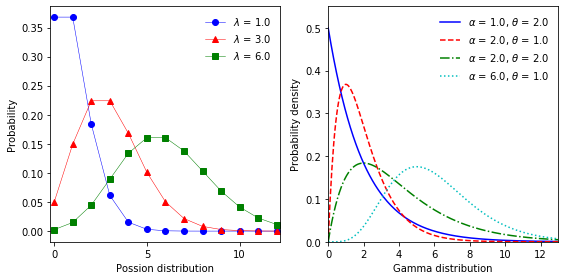

In [2]:
value_l = np.array([1.0, 3.0, 6.0])
value_a = np.array([1.0, 2.0, 2.0, 6.0])
value_t = np.array([2.0, 1.0, 2.0, 1.0])
styles = ['-', '--', '-.', ':']
markers = ['o', '^', 's']
colors = ['b', 'r', 'g', 'c']
fig1, ax1 = plt.subplots(1, 2, num=1, figsize=(8, 4), facecolor='w')
x1 = np.linspace(0, 12, 13)
for index in range(value_l.size):
    l_i = value_l[index]
    plot_label = '$\\lambda$ = {0:3.1f}'.format(l_i)
    ax1[0].plot(x1, st.poisson.pmf(x1, l_i),
               color=colors[index], marker=markers[index],
               linestyle='-', linewidth=0.5, label=plot_label)
ax1[0].set_xlim(-0.2, 12.2)
ax1[0].set_xticks((0, 5, 10))
ax1[0].set_xlabel('Possion distribution')
ax1[0].set_ylabel('Probability')
ax1[0].legend(loc='upper right', frameon=False)
x2 = np.linspace(0, 13, 250)
for index in range(value_a.size):
    a_i = value_a[index]
    t_i = value_t[index]
    plot_label = '$\\alpha$ = {0:3.1f}, $\\theta$ = {1:3.1f}'.format(a_i, t_i)
    ax1[1].plot(x2, st.gamma.pdf(x2, a_i, scale=t_i), color=colors[index],
               linestyle=styles[index], label=plot_label)
ax1[1].set_xlim(0, 13)
ax1[1].set_ylim(0, 0.55)
ax1[1].set_xlabel('Gamma distribution')
ax1[1].set_ylabel('Probability density')
ax1[1].legend(loc='upper right', frameon=False)
plt.tight_layout()
# plt.savefig('ms_fig_poisson_gamma.png', dpi=300)
plt.show()

The likelihood of $\theta$ given $D=(x_1,\dots,x_n)$ is

\begin{align*}
 p(D|\lambda) &= \prod_{i=1}^n p(x_i|\lambda) \\
 &= \prod_{i=1}^n \frac{\lambda^x_i e^{-\lambda}}{x_i!}
 = \frac{\lambda^{\sum_{i=1}^n x_i}e^{-n\lambda}}{\prod_{i=1}^n x_i!}, \\
 &= \frac{\lambda^{y}e^{-n\lambda}}{\prod_{i=1}^n x_i!},\quad
 y = \sum_{i=1}^n x_i.
\end{align*}

Applying Bayes' theorem, we have

\begin{align*}
 p(\lambda|D) &\propto p(D|\lambda)p(\lambda) \\
 &\propto \lambda^{y}e^{-n\lambda}\times\lambda^{\alpha_0-1}e^{-\beta_0 \lambda} \\
 &\propto \lambda^{y+\alpha_0-1}e^{-(n+\beta_0)\lambda} \\
 &\propto \lambda^{\alpha_{\star}-1}e^{-\beta_{\star}\lambda} \\
 \alpha_{\star} &= y + \alpha_0,\quad \beta_{\star} = n + \beta_0.
\end{align*}

This is the gamma distribution $\mathrm{Gamma}(\alpha_{\star},\beta_{\star})$.

In [3]:
def gamma_hpdi(ci0, alpha, theta, prob):
    def hpdi_conditions(v, a, t, p):
        eq1 = st.gamma.cdf(v[1], a, scale=t) - st.gamma.cdf(v[0], a, scale=t) - p
        eq2 = st.gamma.pdf(v[1], a, scale=t) - st.gamma.pdf(v[0], a, scale=t)
        return np.hstack((eq1, eq2))
    return opt.root(hpdi_conditions, ci0, args=(alpha, theta, prob)).x

In [4]:
def poisson_stats(data, a0, b0, prob):
    n = data.size
    a_star = data.sum() + a0
    b_star = n + b0
    theta_star = 1.0 / b_star
    mean_lam = st.gamma.mean(a_star, scale=theta_star)
    median_lam = st.gamma.median(a_star, scale=theta_star)
    mode_lam = (a_star - 1.0) * theta_star
    sd_lam = st.gamma.std(a_star, scale=theta_star)
    ci_lam = st.gamma.interval(prob, a_star, scale=theta_star)
    hpdi_lam = gamma_hpdi(ci_lam, a_star, theta_star, prob)
    stats = np.hstack((mean_lam, median_lam, mode_lam, sd_lam, ci_lam, hpdi_lam)).reshape((1, 8))
    stats_string = ['mean', 'median', 'mode', 'sd', 'ci (lower)', 'ci (upper)', 'hpdi (lower)', 'hpdi (upper)']
    param_string = ['$\\lambda$']
    results = pd.DataFrame(stats, index=param_string, columns=stats_string)
    return results, a_star, b_star

### Application 1: Simulated Data
---

We use artificial data generated from the Poisson distribution:

$$
 x_1,\dots,x_{50} \sim \mathrm{Poisson}(3).
$$

The prior distribution of $\lambda$ is $\mathrm{Gamma}(1,1)$, which is equivalent to the exponential distribution:

$$
 p(x) = e^{-x},\quad x > 0.
$$


In [5]:
lam = 3.0
n = 50
np.random.seed(99)
data = st.poisson.rvs(lam, size=n)
a0 = 1.0
b0 = 1.0
prob = 0.95
results, a_star, b_star = poisson_stats(data, a0, b0, prob)
display(results)

,mean,median,mode,sd,ci (lower),ci (upper),hpdi (lower),hpdi (upper)
$\lambda$,2.901961,2.895427,2.882353,0.23854,2.453271,3.387776,2.440932,3.374032


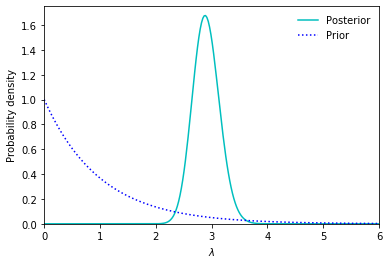

In [6]:
fig2 = plt.figure(num=2, facecolor='w')
x = np.linspace(0, 6, 250)
plt.plot(x, st.gamma.pdf(x, a_star, scale=1.0/b_star), 'c-', label='Posterior')
plt.plot(x, st.gamma.pdf(x, a0, scale=1.0/b0), 'b:', label='Prior')
plt.xlim(0, 6)
plt.ylim(0, 1.75)
plt.xlabel('$\\lambda$')
plt.ylabel('Probability density')
plt.legend(loc='best', frameon=False)
# plt.savefig('ms_fig_poisson_posterior.png', dpi=300)
plt.show()

### Application 2: Prussian army horse kick data
---

#### Variables:

+ y - a numeric vector, count of deaths
+ year - a numeric vector, 18XX, year of observation
+ corp - a factor, corp of Prussian Army generating observation

#### Source:

prussian - Prussian army horse kick data

https://vincentarelbundock.github.io/Rdatasets/datasets.html

von Bortkiewicz, L. 1898. Das Gesetz der Kleinen Zahlen. Leipzig: Teubner.


In [7]:
prussian_data = pd.read_csv('prussian.csv', index_col=0)
horse_kick = prussian_data['y'].values

A Pyplot function `hist` draws a histogram of data. `

+ `bins` - number of bins or a sequence of bins
+ `rwidth` - width of bars in a fraction of the bin width


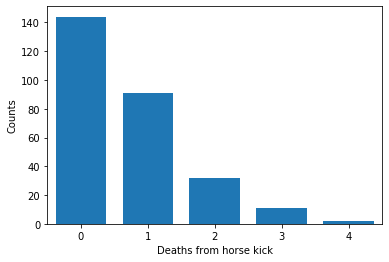

In [8]:
bin_max = np.max(horse_kick)
fig3 = plt.figure(num=3, facecolor='w')
counts, bins, patches = plt.hist(horse_kick, bins=np.linspace(0, bin_max+1, bin_max+2)-0.5, rwidth=0.75)
plt.xlim(-0.5, bin_max+0.5)
plt.xticks(np.linspace(0, bin_max, bin_max+1))
plt.xlabel('Deaths from horse kick')
plt.ylabel('Counts')
# plt.savefig('ms_fig_horse_kick_hist.png', dpi=300)
plt.show()

In [9]:
a0 = 1.0
b0 = 1.0
prob = 0.95
results_horse, a_horse, b_horse = poisson_stats(horse_kick, a0, b0, prob)
display(results_horse)

,mean,median,mode,sd,ci (lower),ci (upper),hpdi (lower),hpdi (upper)
$\lambda$,0.701068,0.699882,0.697509,0.049949,0.606582,0.802292,0.604324,0.799813


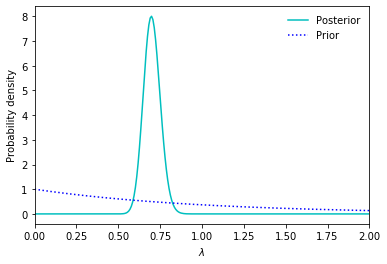

In [10]:
fig4 = plt.figure(num=4, facecolor='w')
x = np.linspace(0, 2, 250)
plt.plot(x, st.gamma.pdf(x, a_horse, scale=1.0/b_horse), 'c-', label='Posterior')
plt.plot(x, st.gamma.pdf(x, a0, scale=1.0/b0), 'b:', label='Prior')
plt.xlim(0, 2)
plt.xlabel('$\\lambda$')
plt.ylabel('Probability density')
plt.legend(loc='best', frameon=False)
# plt.savefig('ms_fig_horse_kick_posterior.png', dpi=300)
plt.show()